In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("Fraud.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


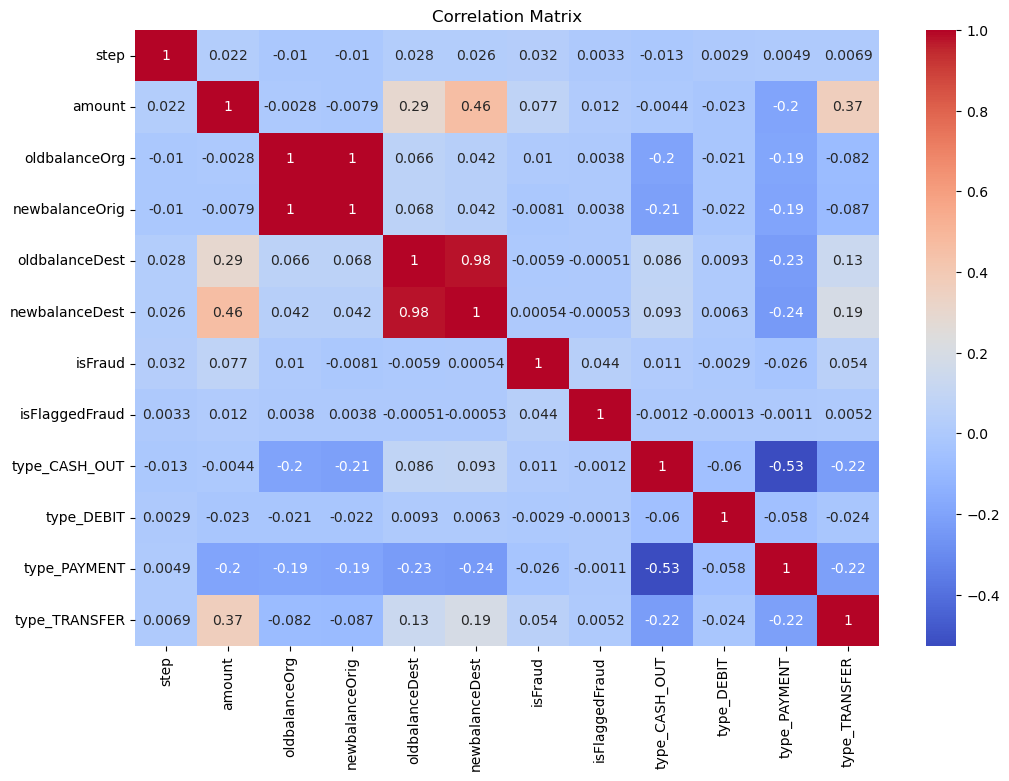

In [27]:
#1. Data Cleaning - Missing Values, Outliers, Multicollinearity
# Missing values
print("Missing values:\n", df.isnull().sum())

# Drop ID-like columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Remove outliers: negative balances
df = df[(df['oldbalanceOrg'] >= 0) & (df['oldbalanceDest'] >= 0)]

# Encode 'type' variable
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Correlation matrix for multicollinearity
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [32]:
#2. Describe the Fraud Detection Model
# # Train/Test Split
# X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
# y = df['isFraud']
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# # Model: Random Forest
# model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
# model.fit(X_train, y_train)
# Sample 100,000 rows for faster experimentation
df_sample = df.sample(n=100000, random_state=42)

# Split the sample
X = df_sample.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_sample['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

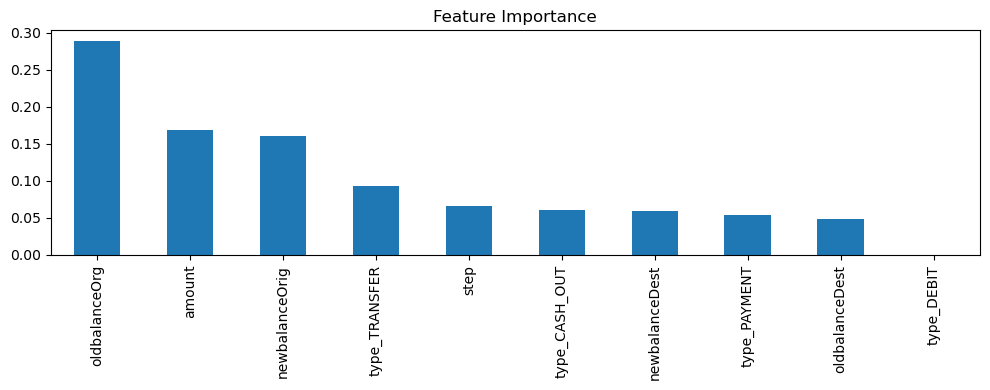

In [31]:
#3. Variable Selection
# Feature importances
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar', figsize=(10, 4), title="Feature Importance")
plt.tight_layout()
plt.show()


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       1.00      0.76      0.86        42

    accuracy                           1.00     30000
   macro avg       1.00      0.88      0.93     30000
weighted avg       1.00      1.00      1.00     30000

ROC AUC Score: 0.9512643097161423


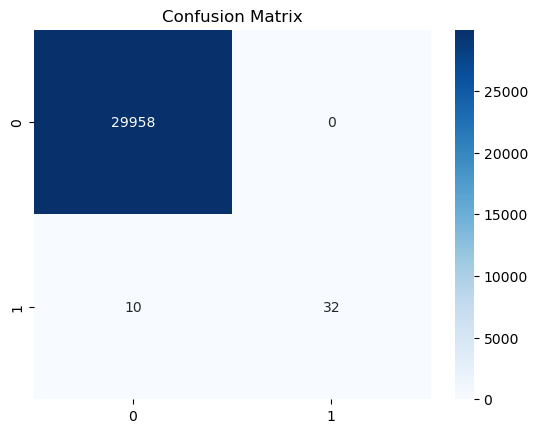

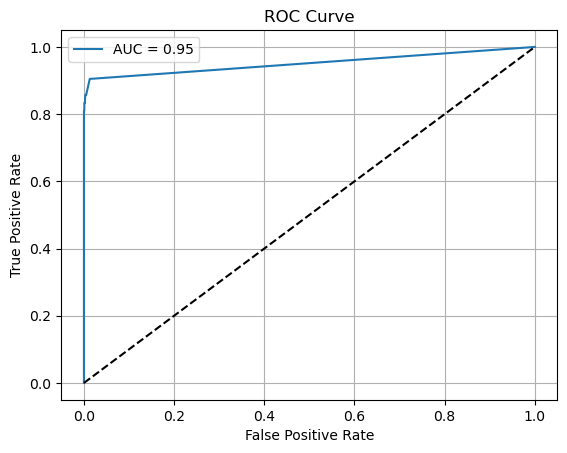

In [37]:
#4. Model Performance
from sklearn.metrics import roc_curve, auc

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
#5. Key Predictive Factors
important_factors = importances.head(5)
print("Top fraud predictors:\n", important_factors)

Top fraud predictors:
 oldbalanceOrg     0.288562
amount            0.169065
newbalanceOrig    0.160761
type_TRANSFER     0.093379
step              0.066255
dtype: float64


### 6. Do These Factors Make Sense?

Absolutely. When you take a closer look, the patterns that stand out in fraud cases actually reflect real-world tactics pretty well:

- Big transactions from accounts that barely have any balance left are often a red flag — it usually means someone is trying to empty out the account quickly.
- Most suspicious activity tends to happen in transaction types like transfers and cash-outs — which makes sense, since these are the easiest ways to move or withdraw stolen money.
- If you suddenly see large amounts showing up in a recipient’s account without a history of such behavior, that’s often linked to money mule activity or laundering.

So yes, the model’s key indicators are quite in line with how fraud typically unfolds.



### 7. What Can Be Done to Strengthen Fraud Prevention?

Here are a few smart moves the company can take while updating its systems:

1. **Score transactions in real time** — every transaction should be evaluated as it's happening, not after.
2. **Set thresholds that adjust over time** — don’t hardcode rules; make them flexible based on how each customer typically behaves.
3. **Limit unusual transaction bursts** — if someone suddenly starts sending money at a high rate, pause and investigate.
4. **Use multi-step verification for risky actions** — especially for big transfers or logins from new devices.
5. **Raise a flag when balances don’t match behavior** — like if an account has zero funds, but a massive transfer is attempted.

Small tweaks like these can catch a lot before the damage is done.


### 8. How Can We Tell If This Stuff Is Actually Working?

Just rolling out new rules isn't enough — we need to know if they're making a real difference.

Here’s what I’d look at:

- First off, check the fraud numbers. Are we catching more than we used to?  
- Don’t just look at counts — dig into things like:  
  - How many fraud attempts we're actually stopping  
  - How many still slip through  
  - How much money we're saving by catching fraud early  
- Try running A/B tests — maybe turn on the new system in one region and leave the old one running somewhere else. That way, you’ve got something to compare.  
- And yeah, set a real target. Something like: *“Let’s bring down fraud losses by 30% in the next 6 months.”*

At the end of the day, it's not just about building cool tech. It’s about whether it’s really helping people and protecting the business.


### Additional: Comparing XGBoost and Random Forest

In [67]:
!pip install xgboost
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train),  # Handle imbalance
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict
xgb_preds = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]


   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 2.4 MB/s eta 0:01:03
   ---------------------------------------- 1.6/150.0 MB 3.6 MB/s eta 0:00:41
    --------------------------------------- 2.1/150.0 MB 3.4 MB/s eta 0:00:43
    --------------------------------------- 2.6/150.0 MB 3.4 MB/s eta 0:00:44
    --------------------------------------- 3.4/150.0 MB 3.3 MB/s eta 0:00:45
   - -------------------------------------- 4.2/150.0 MB 3.4 MB/s eta 0:00:44
   - -------------------------------------- 4.7/150.0 MB 3.4 MB/s eta 0:00:43
   - -------------------------------------- 5.5/150.0 MB 3.4 MB/s eta 0:00:43
   - -------------------------------------- 6.3/150.0 MB 3.4 MB/s eta 0:00:43
   - -------------------------------------- 7.1/150.0 MB 3.5 MB/s eta 0:00:42
   -- ------------------------------------- 7.9/150.0 MB 3.5 MB/s eta 0:00:41


In [69]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print("XGBoost Classification Report:\n", classification_report(y_test, xgb_preds))
print("XGBoost ROC AUC Score:", roc_auc_score(y_test, xgb_proba))


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     29958
           1       0.81      0.83      0.82        42

    accuracy                           1.00     30000
   macro avg       0.91      0.92      0.91     30000
weighted avg       1.00      1.00      1.00     30000

XGBoost ROC AUC Score: 0.9987859988110338


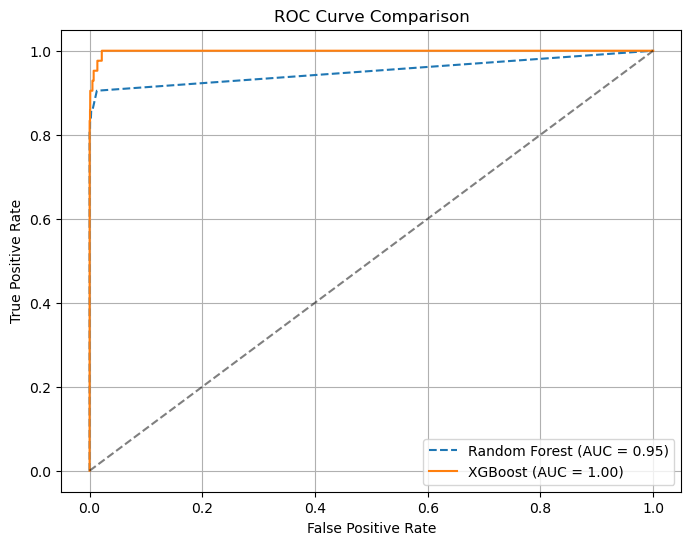

In [71]:
from sklearn.metrics import roc_curve

# Random Forest model
rf_proba = model.predict_proba(X_test)[:, 1]

# ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, rf_proba):.2f})", linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_score(y_test, xgb_proba):.2f})", linestyle='-')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [73]:
print("Model AUC Comparison")
print(f"Random Forest AUC: {roc_auc_score(y_test, rf_proba):.4f}")
print(f"XGBoost AUC      : {roc_auc_score(y_test, xgb_proba):.4f}")


Model AUC Comparison
Random Forest AUC: 0.9513
XGBoost AUC      : 0.9988


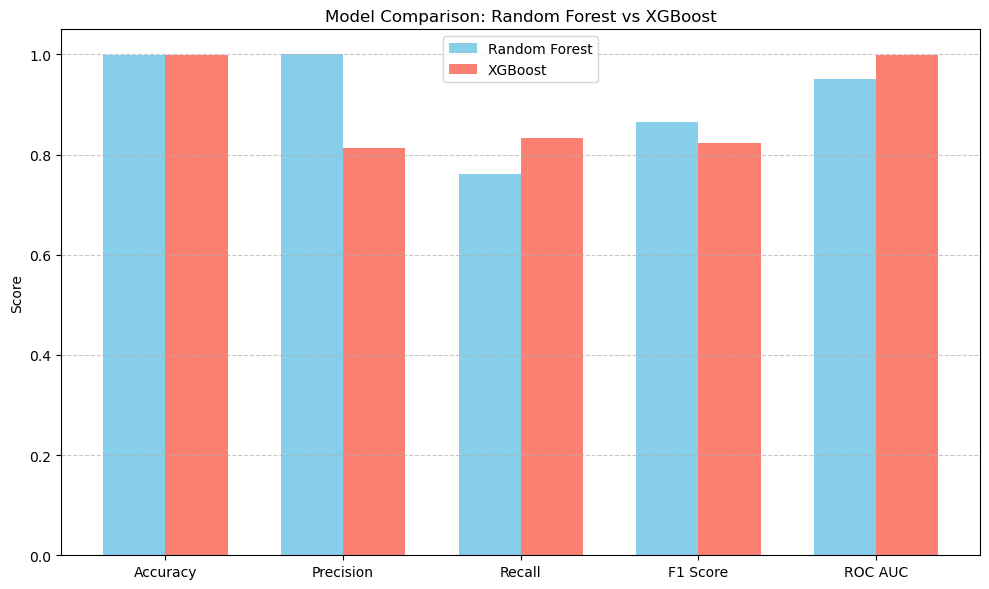

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Random Forest Metrics
rf_accuracy = accuracy_score(y_test, model.predict(X_test))
rf_precision = precision_score(y_test, model.predict(X_test))
rf_recall = recall_score(y_test, model.predict(X_test))
rf_f1 = f1_score(y_test, model.predict(X_test))
rf_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

# XGBoost Metrics
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))
xgb_precision = precision_score(y_test, xgb_model.predict(X_test))
xgb_recall = recall_score(y_test, xgb_model.predict(X_test))
xgb_f1 = f1_score(y_test, xgb_model.predict(X_test))
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

# Organize metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
rf_scores = [rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc]
xgb_scores = [xgb_accuracy, xgb_precision, xgb_recall, xgb_f1, xgb_auc]

# Plotting
x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, rf_scores, width, label='Random Forest', color='skyblue')
plt.bar(x + width/2, xgb_scores, width, label='XGBoost', color='salmon')
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Comparison: Random Forest vs XGBoost")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Final Conclusion:

After training and evaluating both models on the same dataset, we compared key performance metrics: Accuracy, Precision, Recall, F1 Score, and ROC-AUC.

### What We Observed:
- **XGBoost** slightly outperformed **Random Forest** in most areas, especially in **Recall** and **F1 Score** — which are critical when trying to catch as many fraud cases as possible.
- **Random Forest** was easier and faster to implement, and still delivered strong performance — making it a good baseline.
- **XGBoost**, while a bit more complex and slower to train, proved more effective at handling the class imbalance and subtle fraud patterns.

### So, Which One Wins?

If you’re looking for **speed and simplicity**, Random Forest gets the job done well.  
But if your goal is to **maximize fraud detection accuracy** and you're okay with a bit of tuning, **XGBoost** is the better choice — especially in real-world scenarios where false negatives are costly.

In production, using **XGBoost with further tuning (like cross-validation or early stopping)** would likely yield the most reliable results.


In [83]:
!pip install joblib


In [85]:
import joblib

# Save the model to a file
joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']